# Cleaning and EDA of Housing Data

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
import missingno as msno
pd.set_option('display.max_rows', 500)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer


%matplotlib inline

In [3]:
df=pd.read_csv('../datasets/train.csv')
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


## Clean up column names to snake case

In [4]:
def snake_split (df):
    """
    df = pandas dataframe
    
    -------------
    This will convert columns names to snake case 
    and split numeric and categorical column titles
    
    """
    df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('qual','quality')



In [5]:
snake_split(df)
category_cols = df.select_dtypes(include=object).columns
num_cols = df.drop(category_cols, axis=1).columns

## Checking data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
id                    2051 non-null int64
pid                   2051 non-null int64
ms_subclass           2051 non-null int64
ms_zoning             2051 non-null object
lot_frontage          1721 non-null float64
lot_area              2051 non-null int64
street                2051 non-null object
alley                 140 non-null object
lot_shape             2051 non-null object
land_contour          2051 non-null object
utilities             2051 non-null object
lot_config            2051 non-null object
land_slope            2051 non-null object
neighborhood          2051 non-null object
condition_1           2051 non-null object
condition_2           2051 non-null object
bldg_type             2051 non-null object
house_style           2051 non-null object
overall_quality       2051 non-null int64
overall_cond          2051 non-null int64
year_built            2051 non-null int

### Checking for Outliers and Impossible Values

In [7]:
# Look for outliers
df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
id,2051.0,1.474034e+03,8.439808e+02,1.0,753.5,1486.0,2198.0,2930.0
pid,2051.0,7.135900e+08,1.886918e+08,526301100.0,528458140.0,535453200.0,907180080.0,924152030.0
ms_subclass,2051.0,5.700878e+01,4.282422e+01,20.0,20.0,50.0,70.0,190.0
lot_frontage,1721.0,6.905520e+01,2.326065e+01,21.0,58.0,68.0,80.0,313.0
lot_area,2051.0,1.006521e+04,6.742489e+03,1300.0,7500.0,9430.0,11513.5,159000.0


In [8]:
# Garage_yr_blt has an unreasonable construction date in the future.  I'll drop this row, 
# at least until 2207
df['garage_yr_blt'].sort_values(ascending=False).head()

1699    2207.0
144     2010.0
1241    2010.0
589     2009.0
1796    2009.0
Name: garage_yr_blt, dtype: float64

In [9]:
# This house was built in 2006 so garage is likely a typo of 2007

df.loc[1699, 'year_built']
df.loc[1699, 'garage_yr_blt']= 2007

In [10]:
def check_data(dataframe):
    print(dataframe.head())
    print('')
    print('='*25)
    print('')
    msno.matrix(dataframe)
    print('')
    print('='*25)
    print('')
    print(df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False))
    print('')
    print('='*25)
    print('')
    print(dataframe.info())

    id        pid  ms_subclass  lot_frontage  lot_area  overall_quality  \
0  109  533352170           60           NaN     13517                6   
1  544  531379050           60          43.0     11492                7   
2  153  535304180           20          68.0      7922                5   
3  318  916386060           60          73.0      9802                5   
4  255  906425045           50          82.0     14235                6   

   overall_cond  year_built  year_remod/add  mas_vnr_area  ...  wood_deck_sf  \
0             8        1976            2005         289.0  ...             0   
1             5        1996            1997         132.0  ...             0   
2             7        1953            2007           0.0  ...             0   
3             5        2006            2007           0.0  ...           100   
4             8        1900            1993           0.0  ...             0   

   open_porch_sf  enclosed_porch  3ssn_porch  screen_porch  pool_are

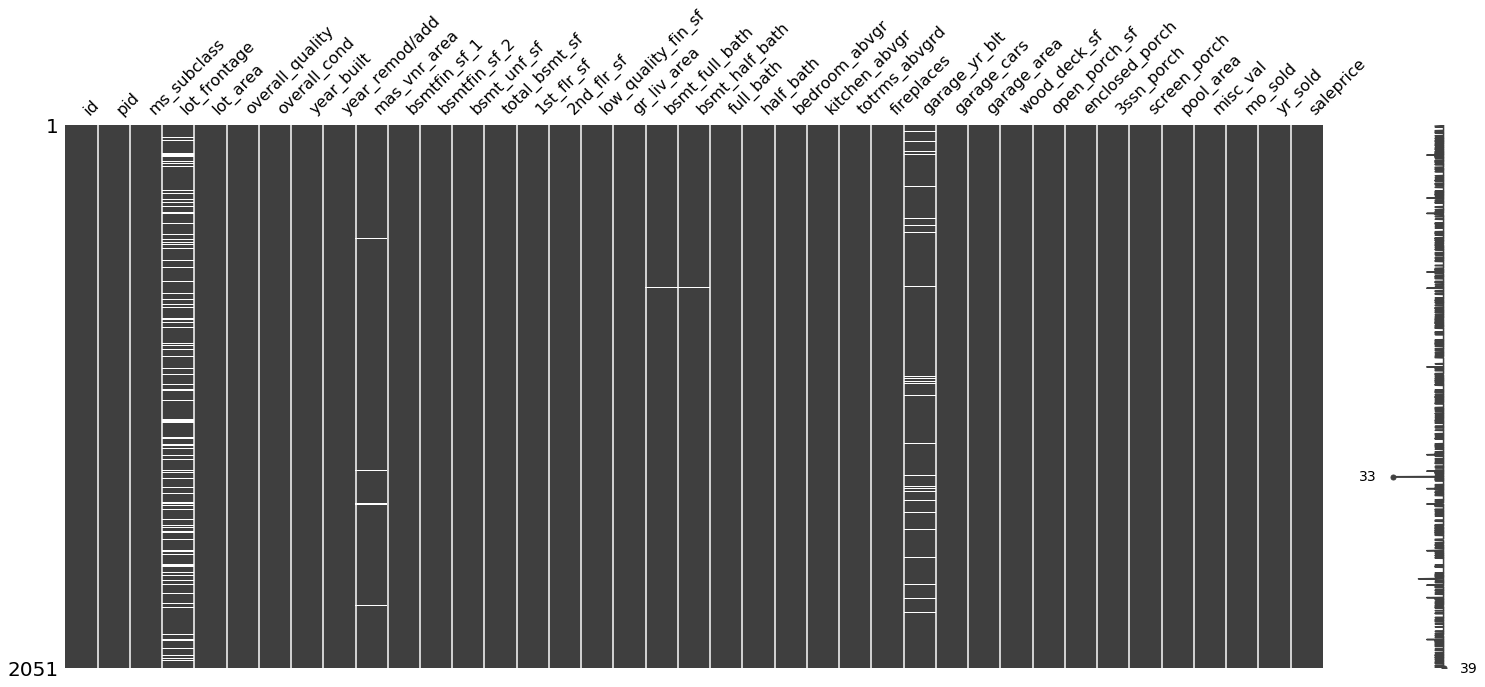

In [11]:
check_data(df[num_cols])

In [12]:
# df[num_cols].fillna({np.NaN: 0}, inplace=True)
# df.loc.num_cols.fillna(value=0, inplace=True)
df[num_cols]=df[num_cols].fillna(0)
df[num_cols].isnull().sum()

id                    0
pid                   0
ms_subclass           0
lot_frontage          0
lot_area              0
overall_quality       0
overall_cond          0
year_built            0
year_remod/add        0
mas_vnr_area          0
bsmtfin_sf_1          0
bsmtfin_sf_2          0
bsmt_unf_sf           0
total_bsmt_sf         0
1st_flr_sf            0
2nd_flr_sf            0
low_quality_fin_sf    0
gr_liv_area           0
bsmt_full_bath        0
bsmt_half_bath        0
full_bath             0
half_bath             0
bedroom_abvgr         0
kitchen_abvgr         0
totrms_abvgrd         0
fireplaces            0
garage_yr_blt         0
garage_cars           0
garage_area           0
wood_deck_sf          0
open_porch_sf         0
enclosed_porch        0
3ssn_porch            0
screen_porch          0
pool_area             0
misc_val              0
mo_sold               0
yr_sold               0
saleprice             0
dtype: int64

## Get Dummies for Categorical Columns

In [13]:
df[category_cols].head()

,ms_zoning,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,...,fireplace_qu,garage_type,garage_finish,garage_quality,garage_cond,paved_drive,pool_qc,fence,misc_feature,sale_type
0,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,...,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD
1,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD
2,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD
3,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,...,NaN,BuiltIn,Fin,TA,TA,Y,NaN,NaN,NaN,WD
4,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,...,NaN,Detchd,Unf,TA,TA,N,NaN,NaN,NaN,WD


In [14]:
df.shape

(2051, 81)

In [15]:
df_dummies =pd.get_dummies(df,drop_first=True)
df_dummies.columns = df_dummies.columns.str.lower()
df_dummies.shape

(2051, 250)

In [16]:
# ms sub class looks numeric, but is categorical

ms_class_dummy = {20:'1-STORY 1946 & NEWER ALL STYLES',
   30:'1-STORY 1945 & OLDER',
   40:'1-STORY W/FINISHED ATTIC ALL AGES',
   45:'1-1/2 STORY - UNFINISHED ALL AGES',
   50:'1-1/2 STORY FINISHED ALL AGES',
   60:'2-STORY 1946 & NEWER',
   70:'2-STORY 1945 & OLDER',
   75:'2-1/2 STORY ALL AGES',
   80:'SPLIT OR MULTI-LEVEL',
   85:'SPLIT FOYER',
   90:'DUPLEX - ALL STYLES AND AGES',
   120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
   150:'1-1/2 STORY PUD - ALL AGES',
   160:'2-STORY PUD - 1946 & NEWER',
   180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
   190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}

In [17]:
df_dummies['ms_subclass'] = df_dummies['ms_subclass'].apply(lambda x: ms_class_dummy[x])

In [18]:
df_dummies['ms_subclass'].unique()

array(['2-STORY 1946 & NEWER', '1-STORY 1946 & NEWER ALL STYLES',
       '1-1/2 STORY FINISHED ALL AGES',
       'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
       '2-STORY PUD - 1946 & NEWER', '2-STORY 1945 & OLDER',
       '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
       '2 FAMILY CONVERSION - ALL STYLES AND AGES', 'SPLIT FOYER',
       '1-STORY 1945 & OLDER', 'DUPLEX - ALL STYLES AND AGES',
       'SPLIT OR MULTI-LEVEL', '2-1/2 STORY ALL AGES',
       '1-1/2 STORY - UNFINISHED ALL AGES',
       '1-STORY W/FINISHED ATTIC ALL AGES', '1-1/2 STORY PUD - ALL AGES'],
      dtype=object)

In [19]:
ms_dum = pd.get_dummies(df_dummies['ms_subclass'], drop_first=True)
df_dummies= pd.concat([df_dummies, ms_dum], axis=1)
df_dummies.columns = df_dummies.columns.str.lower().str.replace('-','_').str.replace(' ','_')

In [20]:
df_dummies.columns = df_dummies.columns.str.lower().str.replace('-','_').str.replace(' ','_')
df_dummies.shape


(2051, 265)

## EDA

In [21]:
def corr_rank (df, target):
    
    """
    df = pandas dataframe or matrix
    target = target variable or column from dataframe
    """
    y= df[target]
    plt.figure(figsize=(10,50))
    sns.heatmap(df.corr()[[target]].sort_values(by = target, 
                                                    ascending=False),
               annot = True,
               cmap='RdBu_r',

               );

In [22]:
# Scatter plots for many variables and Y for regression prep

def plt_subplots(df, columns,y_var, ncols=2):
    
    """
    df = dataframe
    columns = X variable columns names
    y_var = target variable
    ncols = cumber of columns  of subplots
    
    """
    nrows = int(np.ceil((len(columns))/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (10, 2.5 * nrows))
    plt.style.use('bmh')
    plt.tight_layout(pad=3)
# this is the most important line of the function.  .ravel returns a flattened array
#    of the data instead of a matrix.
    ax = ax.ravel()
    for i, col in enumerate(columns):
        
        if i % 2 == 0:
            color = 'blue'
            alpha = 0.7
        else:
            color = 'black'
            alpha = 0.8

        ax[i].scatter(df[col], y=y_var, color=color, alpha=alpha, s=2 )       #plot histogram
        ax[i].set_title(col)
        ax[i].set_ylabel('Price')
        ax[i].set_xlabel(col)

In [23]:
# Sub plot hist for many variables

def plt_hists(df, columns, ncols=2):
    nrows = int(np.ceil((len(columns))/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (12, 2.5 * nrows))
    plt.style.use('bmh')
    plt.tight_layout(pad=3)
  
    #this is the most important line of the function.  .ravel returns a flattened array
#    of the data instead of a matrix.
    ax = ax.ravel()
    for i, col in enumerate(columns):
        
        if i % 2 == 0:
            color = 'blue'
            alpha = 0.7
        else:
            color = 'black'
            alpha = 0.8

        ax[i].hist(df[col], color=color, alpha=alpha)       #plot histogram
        ax[i].set_title(col)
        ax[i].set_ylabel('Frequency')
        ax[i].set_xlabel('')
        ax[i].axvline(df[col].mean(), color='red', linewidth=2)   # Mean line

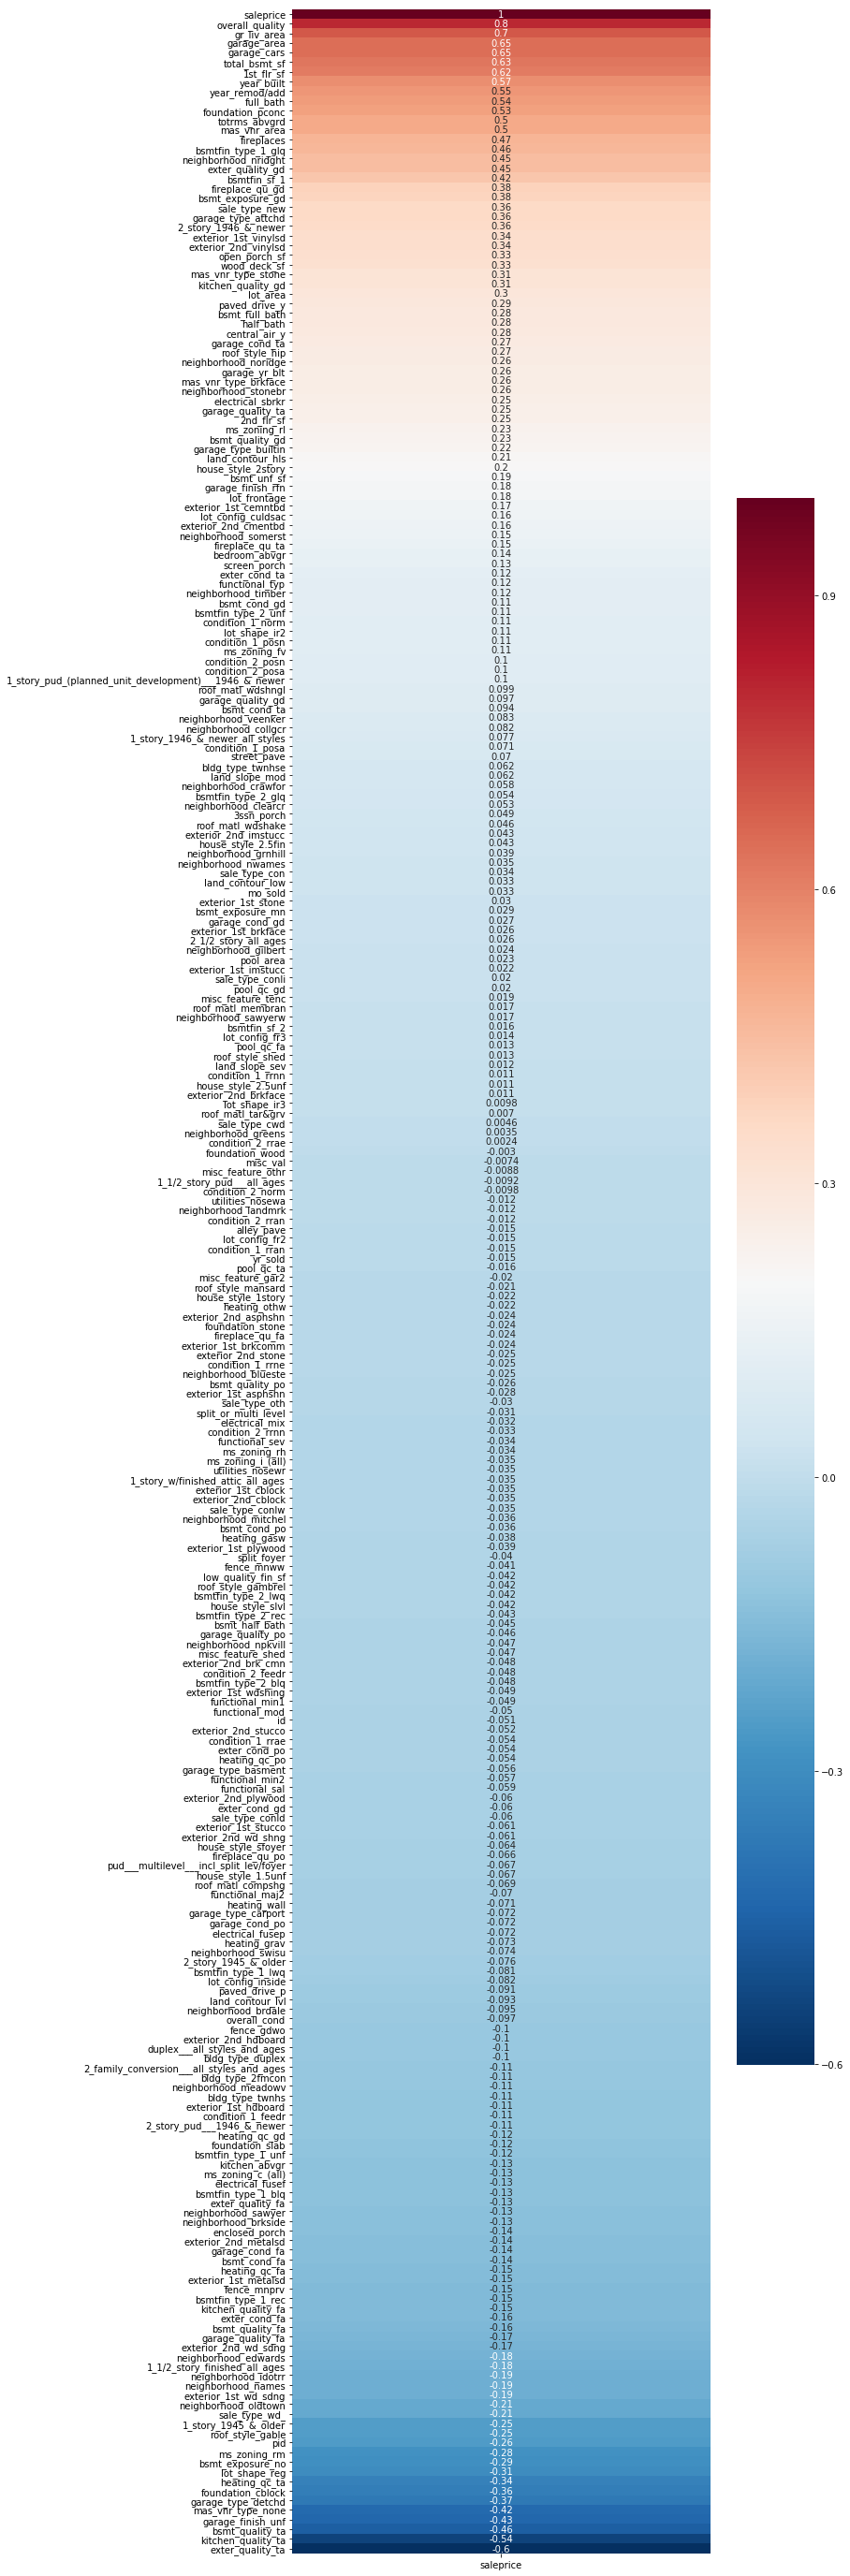

In [24]:
corr_rank(df_dummies, 'saleprice')

In [25]:
features_Q=['exter_quality_ta','kitchen_quality_ta',
            'bsmt_quality_ta','garage_finish_unf',
            'mas_vnr_type_none','garage_type_detchd',
            'overall_quality','gr_liv_area',
            'garage_area','garage_cars',
            'total_bsmt_sf','1st_flr_sf',
            'year_built','year_remod/add',
            'full_bath','foundation_pconc',
            'totrms_abvgrd','mas_vnr_area'
            ]
X_Q= df_dummies[features_Q]
y= df_dummies['saleprice']

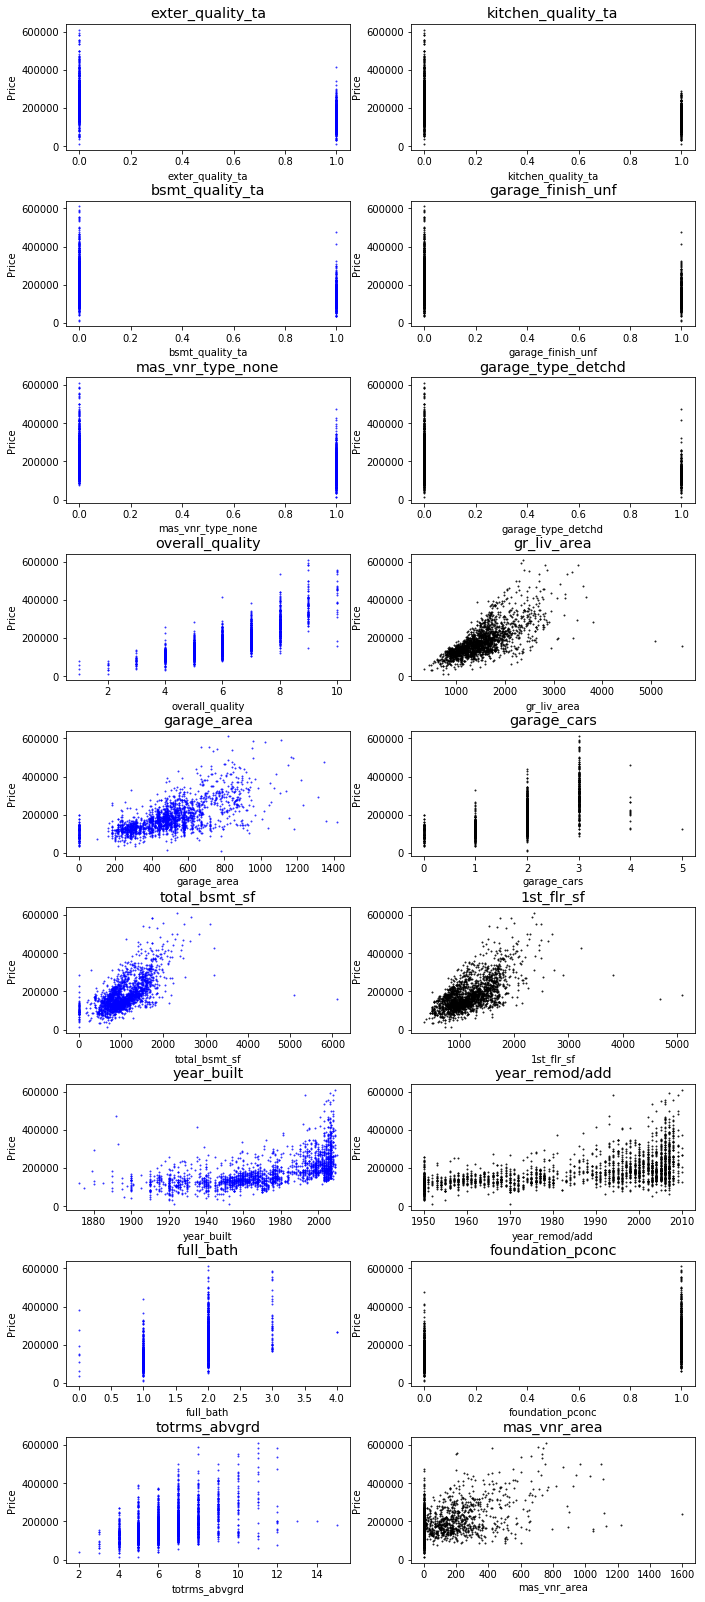

In [26]:
plt_subplots(df_dummies, features_Q, df_dummies['saleprice'])

In [27]:
df_dummies.loc[df_dummies['gr_liv_area']> 4000]  #960 and 1885
df_dummies.loc[df_dummies['total_bsmt_sf']> 4000] # Same
df_dummies.loc[df_dummies['1st_flr_sf']> 3500] # same + 616
df_dummies.loc[df_dummies['mas_vnr_area']> 1200] # 1885 and 1409 (1600)

,id,pid,ms_subclass,lot_frontage,lot_area,overall_quality,overall_cond,year_built,year_remod/add,mas_vnr_area,...,1_story_w/finished_attic_all_ages,2_family_conversion___all_styles_and_ages,2_1/2_story_all_ages,2_story_1945_&_older,2_story_1946_&_newer,2_story_pud___1946_&_newer,duplex___all_styles_and_ages,pud___multilevel___incl_split_lev/foyer,split_foyer,split_or_multi_level
1409,1850,533241030,2-STORY 1946 & NEWER,66.0,7399,7,5,1997,1998,1600.0,...,0,0,0,0,1,0,0,0,0,0
1885,2181,908154195,1-STORY 1946 & NEWER ALL STYLES,128.0,39290,10,5,2008,2009,1224.0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df_dummies.shape

(2051, 265)

In [29]:

# Dropping 2 outliers
df_dummies.drop([960,1885], inplace=True)

In [30]:
df_dummies.shape

(2049, 265)

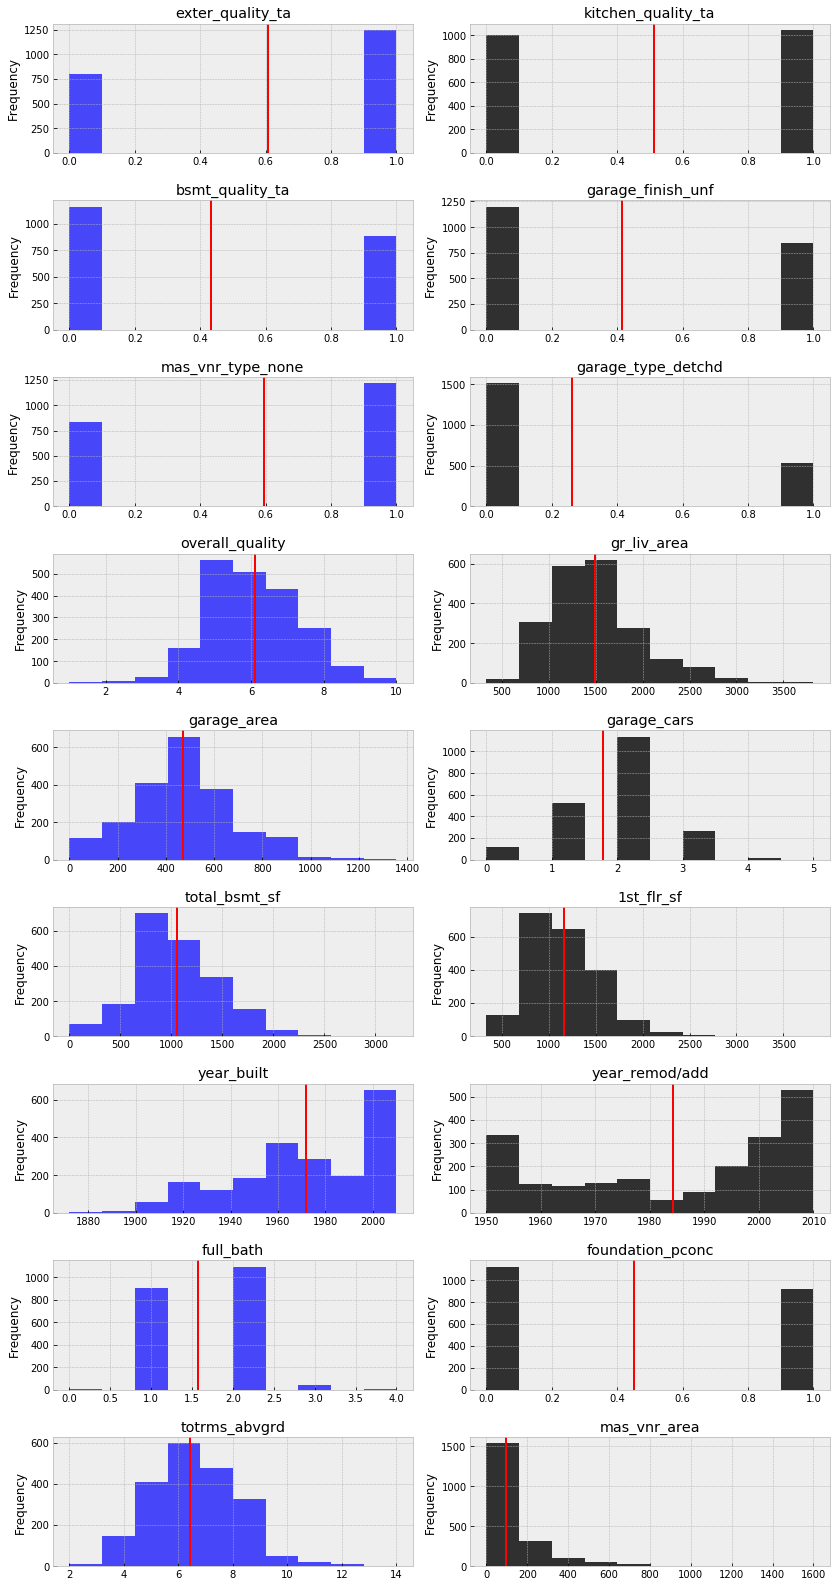

In [31]:
plt_hists(df_dummies, features_Q)

### Combine some related features into interaction features

In [32]:
df_dummies.shape

(2049, 265)

In [33]:
pd.set_option('display.max_rows', 500)
hi_corr=df_dummies.corr().abs().unstack().sort_values(kind="quicksort", ascending=False)
hi_corr[255:275]


neighborhood_timber                        neighborhood_timber                          1.000000
neighborhood_veenker                       neighborhood_veenker                         1.000000
condition_1_feedr                          condition_1_feedr                            1.000000
condition_1_norm                           condition_1_norm                             1.000000
condition_1_posa                           condition_1_posa                             1.000000
condition_1_posn                           condition_1_posn                             1.000000
condition_1_rrae                           condition_1_rrae                             1.000000
condition_1_rran                           condition_1_rran                             1.000000
condition_1_rrne                           condition_1_rrne                             1.000000
condition_1_rrnn                           condition_1_rrnn                             1.000000
duplex___all_styles_and_ages  

In [34]:
# There are several features that seem to be dependent on eachother and could be combined into 
# interaction features.
def interaction_columns(df_dummies):
    """
    df_dummies = dataframe to manipulate, most likely the test df.
    
    """
    df_dummies['garage_area*garage_cars'] = df_dummies['garage_area'] * df_dummies['garage_cars']
    df_dummies['ms_zoning_fv*neighborhood_somerst'] = df_dummies['ms_zoning_fv'] * df_dummies['neighborhood_somerst']
    df_dummies['gr_liv_area*totrms_abvgrd'] = df_dummies['gr_liv_area'] * df_dummies['totrms_abvgrd']
    df_dummies['2nd_flr_sf*house_style_2story']=df_dummies['2nd_flr_sf']*df_dummies['house_style_2story']
    df_dummies['exterior_2nd_brk_cmn*neighborhood_npkvill']=df_dummies['exterior_2nd_brk_cmn']*df_dummies['neighborhood_npkvill']
    df_dummies['gr_liv_area*1st_flr_sf']=df_dummies['gr_liv_area']*df_dummies['1st_flr_sf']
    df_dummies['kitchen_quality_ta*exterior_quality_ta']=df_dummies['kitchen_quality_ta']*df_dummies['exter_quality_ta']


In [35]:
interaction_columns(df_dummies)
df_dummies.shape

(2049, 272)

### Saving clean dataset

In [36]:
df_dummies.to_csv('../datasets/df_dummies_clean.csv', index=False)

### Cleaning Test File

     Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch Pool Area Pool QC  \
0  Grvl       Reg          Lvl  ...          0            0         0     NaN   
1   NaN       IR1          Lvl  ...          0            0         0     NaN   
2   NaN       IR1          Lvl  ...          0            0         0     NaN   
3   NaN       Reg          Lvl  ...          0            0         0     NaN   
4   NaN       IR1          Lvl  ...          0          185         0     NaN   

  Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Typ

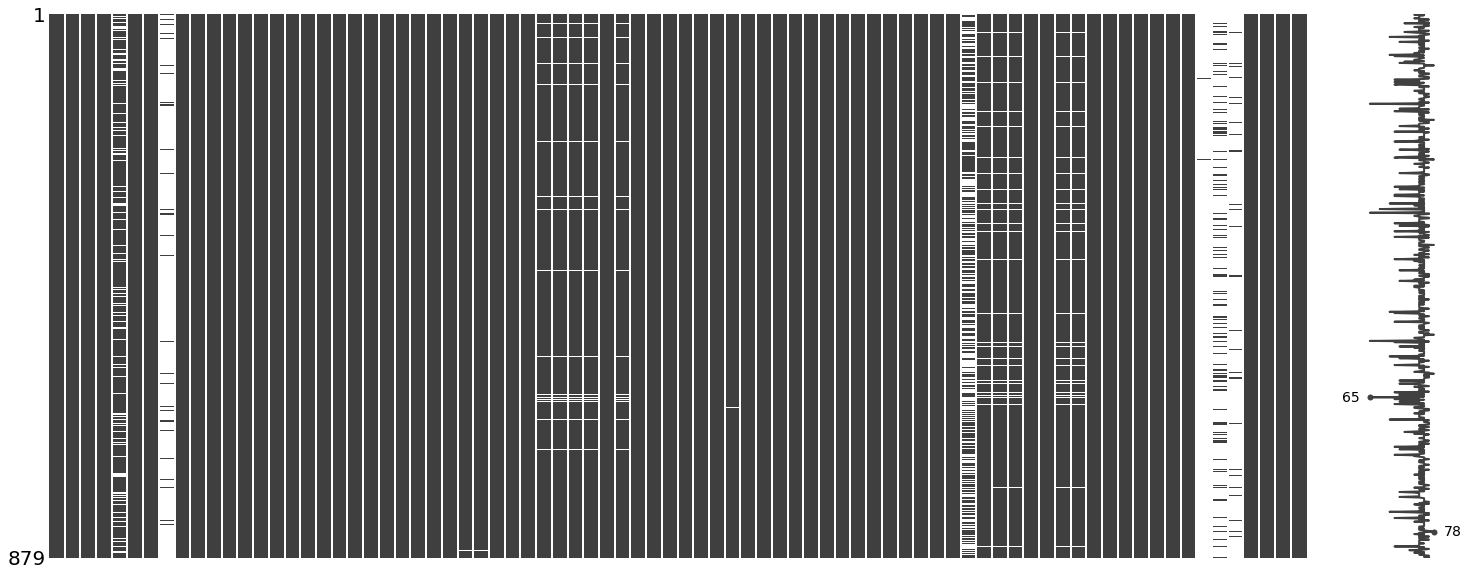

In [37]:
test=pd.read_csv('../datasets/test.csv')
check_data(test)

In [38]:
# Clean up Test dataset to match Train
snake_split(test)

     id        pid  ms_subclass  lot_frontage  lot_area  overall_quality  \
0  2658  902301120          190          69.0      9142                6   
1  2718  905108090           90           NaN      9662                5   
2  2414  528218130           60          58.0     17104                7   
3  1989  902207150           30          60.0      8520                5   
4   625  535105100           20           NaN      9500                6   

   overall_cond  year_built  year_remod/add  mas_vnr_area  ...  garage_area  \
0             8        1910            1950           0.0  ...          440   
1             4        1977            1977           0.0  ...          580   
2             5        2006            2006           0.0  ...          426   
3             6        1923            2006           0.0  ...          480   
4             5        1963            1963         247.0  ...          514   

   wood_deck_sf  open_porch_sf  enclosed_porch  3ssn_porch  screen_p

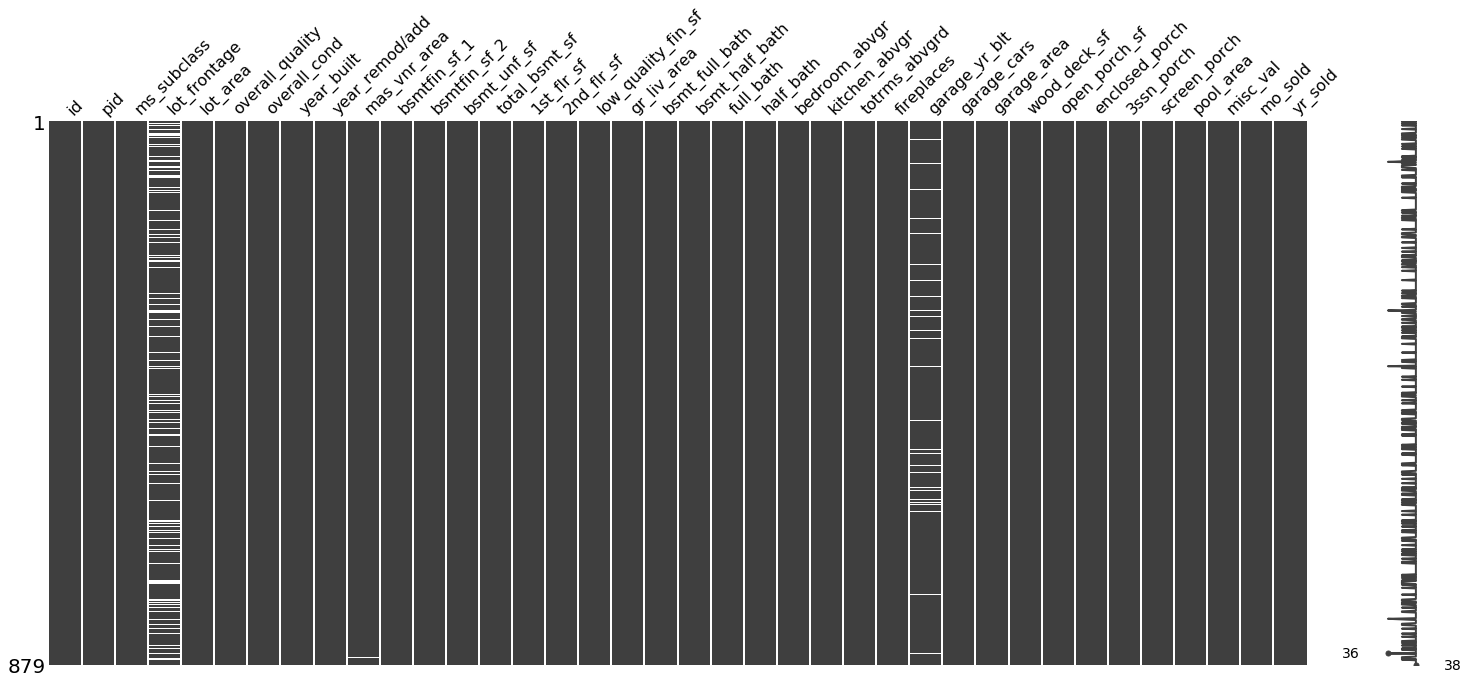

In [39]:
# Seperate numeric and categorical columns
t_category_cols = test.select_dtypes(include=object).columns
t_num_cols = test.drop(category_cols, axis=1).columns
check_data(test[t_num_cols])
print(test.shape)
# Add dummies
test =pd.get_dummies(test,drop_first=True)
print(test.shape)
test.columns = test.columns.str.lower()
test['ms_subclass'] = test['ms_subclass'].apply(lambda x: ms_class_dummy[x])
ms_dummies = pd.get_dummies(test['ms_subclass'], drop_first=True)
test = pd.concat([test, ms_dummies], axis=1)
print(test.shape)
test.columns = test.columns.str.lower().str.replace('-','_').str.replace(' ','_')
# Add Interaction Columns
interaction_columns(test)
print(test.shape)

In [40]:
test[t_num_cols]=test[t_num_cols].fillna(0)
test[t_num_cols].isnull().sum()

id                    0
pid                   0
ms_subclass           0
lot_frontage          0
lot_area              0
overall_quality       0
overall_cond          0
year_built            0
year_remod/add        0
mas_vnr_area          0
bsmtfin_sf_1          0
bsmtfin_sf_2          0
bsmt_unf_sf           0
total_bsmt_sf         0
1st_flr_sf            0
2nd_flr_sf            0
low_quality_fin_sf    0
gr_liv_area           0
bsmt_full_bath        0
bsmt_half_bath        0
full_bath             0
half_bath             0
bedroom_abvgr         0
kitchen_abvgr         0
totrms_abvgrd         0
fireplaces            0
garage_yr_blt         0
garage_cars           0
garage_area           0
wood_deck_sf          0
open_porch_sf         0
enclosed_porch        0
3ssn_porch            0
screen_porch          0
pool_area             0
misc_val              0
mo_sold               0
yr_sold               0
dtype: int64

In [41]:
test.shape

(879, 252)

In [42]:
# Checking what the missing columns in the test df are
missing_columns=list(set(df_dummies.columns).symmetric_difference(test.columns))
missing_columns

['exterior_1st_imstucc',
 'condition_2_rran',
 'roof_matl_membran',
 'condition_2_feedr',
 'heating_qc_po',
 'exterior_1st_stone',
 'exterior_1st_precast',
 'exterior_1st_cblock',
 'exterior_2nd_other',
 'condition_2_rrae',
 'functional_sal',
 'heating_gasa',
 'ms_zoning_c_(all)',
 'roof_matl_compshg',
 'misc_feature_tenc',
 'sale_type_vwd',
 'bsmt_cond_fa',
 'misc_feature_gar2',
 'electrical_mix',
 'neighborhood_grnhill',
 'neighborhood_landmrk',
 'pool_qc_gd',
 'utilities_nosewa',
 'exterior_2nd_stone',
 'functional_sev',
 'pool_qc_fa',
 'heating_othw',
 'kitchen_quality_po',
 'mas_vnr_type_cblock',
 'bsmt_cond_po',
 'heating_wall',
 'condition_2_rrnn',
 '1_1/2_story_pud___all_ages',
 'roof_matl_metal',
 'garage_quality_fa',
 'roof_matl_roll',
 'saleprice',
 'exterior_2nd_precast']

In [51]:
# Add missing columns
for col in missing_columns:
    test[col]=0

In [52]:
df_dummies.shape

(2049, 272)

In [191]:
test.to_csv('../datasets/test_clean.csv', index=False)

### EDA
- Check which neghborhoods have correlation
     - Make dummy columns and check correlation
     - drop the ones that don't
- 

In [ ]:
# Scatter plots of variables

def plt_subplots(df, columns,y_var, ncols=2):
    nrows = int(np.ceil((len(columns))/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (10, 2.5 * nrows))
    plt.style.use('bmh')
    plt.tight_layout(pad=3)
#this is the most important line of the function.  .ravel returns a flattened array
#    of the data instead of a matrix.
    ax = ax.ravel()
    for i, col in enumerate(columns):
        
        if i % 2 == 0:
            color = 'blue'
            alpha = 0.7
        else:
            color = 'black'
            alpha = 0.8

        ax[i].scatter(df[col], y=y_var, color=color, alpha=alpha, s=2 )       #plot histogram
        ax[i].set_title(col)
        ax[i].set_ylabel('Price')
        ax[i].set_xlabel(col)
        ax[i].axvline(df[col].mean(), color='red', linewidth=2)   # Mean line
        

In [ ]:
def plot_vars(model, X, y, ncols=2):
    """
    Plots predicted values compared to actual
    
    ____
    model = regression model
    X = matrix or dataframe of features
    y = target value series
    ncols= number of columns of scatter charts
    """
    
    nrows = int(np.ceil((len(X))/2))
#     plt.figure(figsize=(12,9))
    plt.style.use('bmh')
    #plt.tight_layout(pad=3);
#     fig, ax = plt.subplots(1,len(X.columns.values),
#                            ncols=ncols,
#                            sharey=True
                          #constrained_layout=True)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (10, 2.5 * nrows))
    for i,e in enumerate(X.columns):
      model=model()
      model.fit(X[e].values[:,np.newaxis], y.values)
      ax[i].set_title("Best fit line")
      ax[i].set_xlabel(str(e))
      ax[i].set_ylabel('Sale Price')
      ax[i].scatter(X[e].values[:,np.newaxis], y,color='g')
      ax[i].plot(X[e].values[:,np.newaxis], 
      model.predict(X[e].values[:,np.newaxis]),color='k')
# Generate a scatterplot of predicted values versus actual values.
    plt.scatter(model.predict(X), y, s=8, color='skyblue', alpha = 0.9)

# Plot a line.
    plt.plot([0, np.max(y)],
             [0, np.max(y)],
             color = 'black')

 # Tweak title and axis labels.
    plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
    plt.ylabel("Actual Values: $y$", fontsize = 20)
    plt.text(1,1,'Pre', transform=ax[i].transAxes)
    plt.title('Predicted Values vs. Actual Values', fontsize = 24);

In [ ]:
plt_subplots(df, num_cols, df['saleprice'])

There are some numeric columns that I can drop fromm my analysis.
- pid
- id
- bsmtfin_sf_2
- bsmt_unf_sf
- low_quality_fin_sf
- bsmt_full_bath
- bsmt_half_bath
- kitchen_abvgr
- 3ssn_porch
- screen_porch
- pool_area
- misc_val

In [ ]:
features=num_cols.drop(['pid',
'id',
'bsmtfin_sf_2',
'bsmt_unf_sf',
'low_quality_fin_sf',
'bsmt_full_bath',
'bsmt_half_bath',
'kitchen_abvgr',
'3ssn_porch',
'screen_porch',
'pool_area',
'misc_val',
'saleprice'
])
features

In [ ]:
X=df[features]
y=df['saleprice']

In [ ]:
plot_vars(LinearRegression, X, y)

In [ ]:
# Create a baseline score
lr = LinearRegression()
cross_val_score(lr,X, y, cv=5).mean()

### Plot histograms of all of the numeric columns

In [229]:
df_dummies[num_cols].shape

(2049, 39)

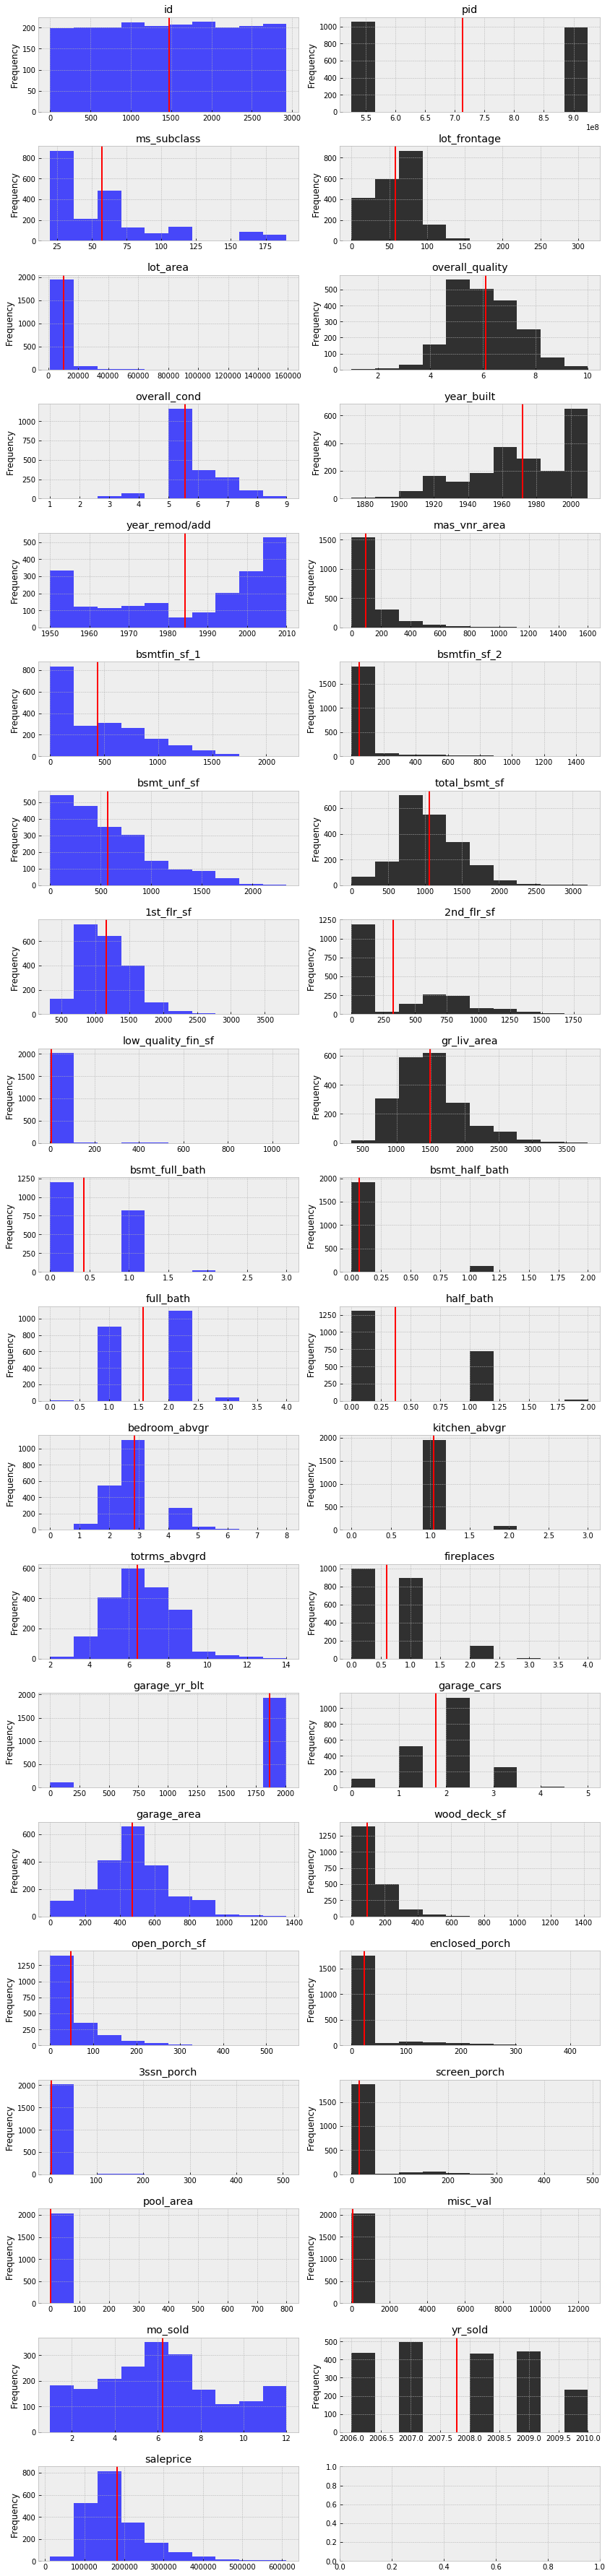

In [234]:
plt_hists(df_dummies, num_cols)

In [246]:
# Trying polynomial features
poly = PolynomialFeatures(include_bias=False)
features_poly=['mo_sold',
              'open_porch_sf',
              'wood_deck_sf',
              'garage_area',
              'garage_cars',
              'fireplaces',
              'totrms_abvgrd',
              'bedroom_abvgr',
              'full_bath',
              'bsmt_full_bath',
              'gr_liv_area',
              '2nd_flr_sf',
              '1st_flr_sf',
              'bsmt_unf_sf',
              'overall_cond',
              'overall_quality']
X = df_dummies[features_poly]
X_poly = poly.fit_transform(X)
df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(features_poly))
df_poly['saleprice']=df_dummies['saleprice']


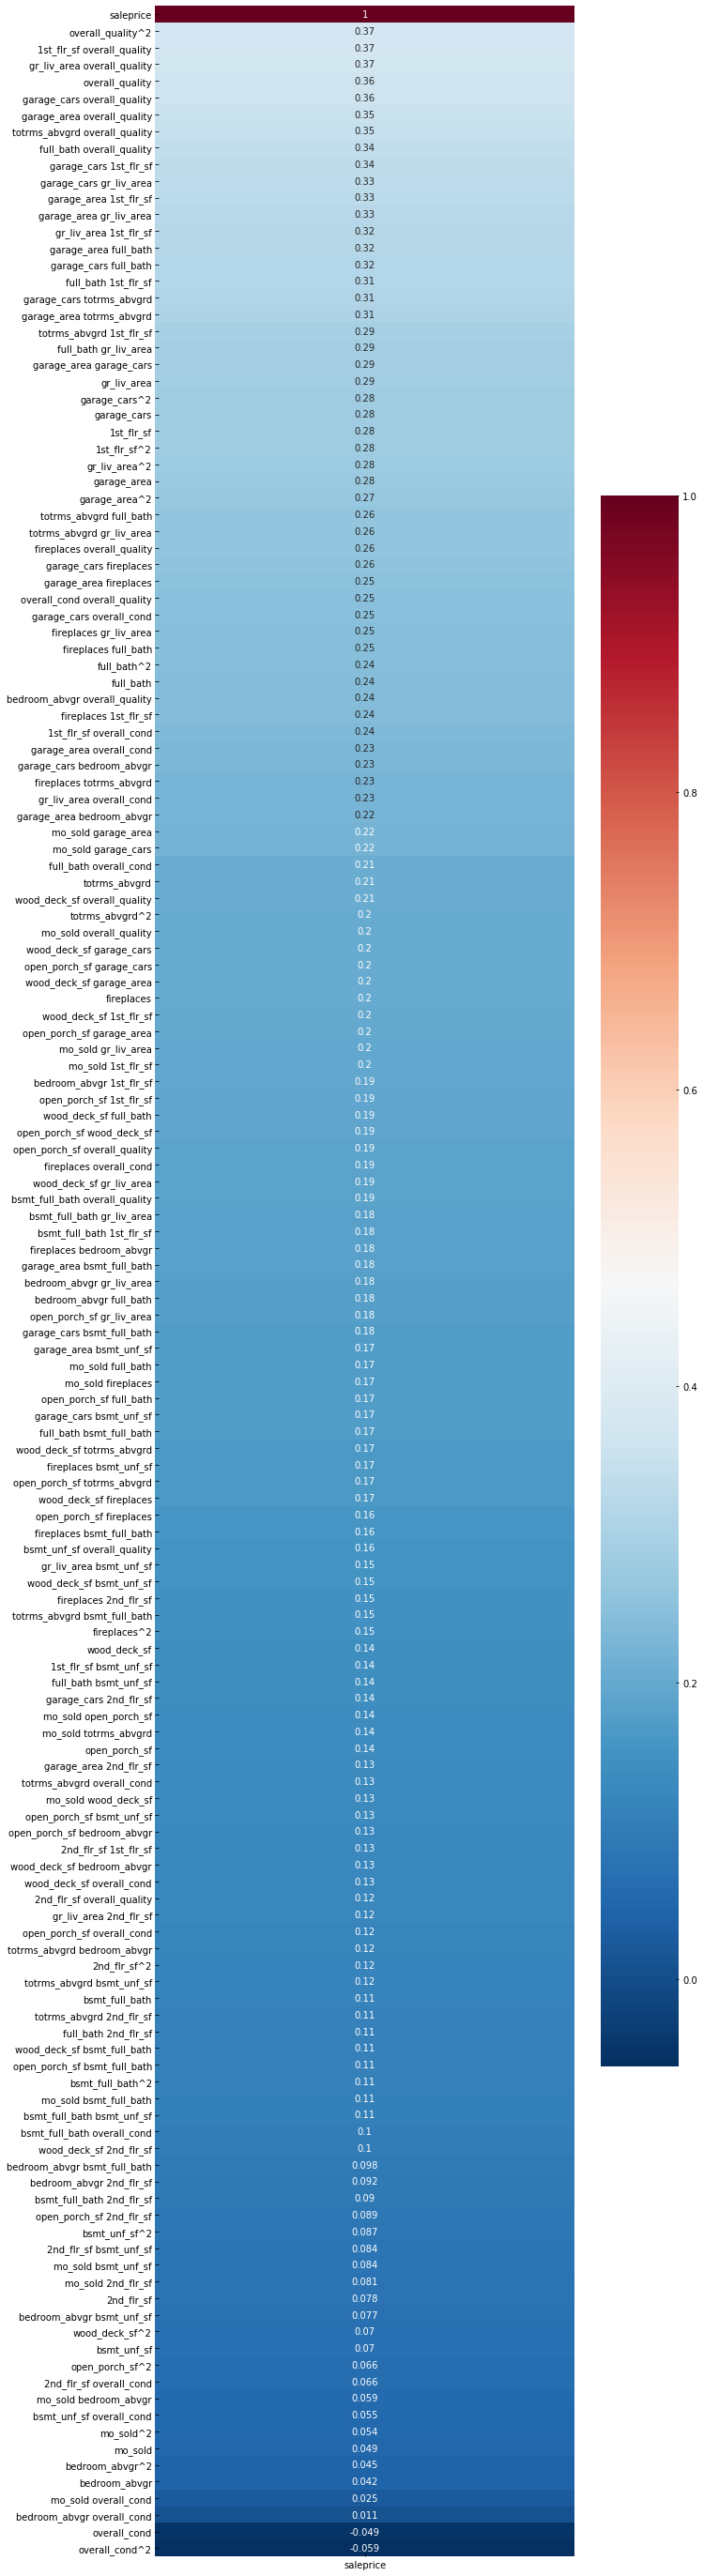

In [248]:
corr_rank(df_poly,'saleprice')

In [ ]:
pt = PowerTransformer()
pt.fit(X_train)
X_train = pt.transform(X_train)
X_test = pt.transform(X_test)

pt_y = PowerTransformer()
# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

In [232]:
# ms subclass column is not numeric and should be put into categorical and dummies columns

## Questions
- What is the best way to take the log of a numeric column that has zero's in it?
- If I train my model with the log of the target variable (log_salesprice), won't that give false expectations of scores, because the actual test values will not be log?
- 